In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
config_df = pd.read_csv("sbert.csv")
epoch_df = pd.read_csv("sbert_epoch.csv")
epoch_df.head()
config_df.head()

,config_id,type_test,model_name,dataset_type,pooling_type,batch_size,epochs,learning_rate,attention_dropout,hidden_dropout,...,peak_memory,reg_train_loss,reg_train_rmse,reg_train_pearson,reg_valid_loss,reg_valid_rmse,reg_valid_pearson,reg_test_loss,reg_test_rmse,reg_test_pearson
0,0,model_test,sentence-transformers/distiluse-base-multiling...,before preprocessing,mean,16,8,0.00002,0.1,0.1,...,7543.489746,0.001493,0.038637,0.989817,0.011643,0.107903,0.912139,0.008053,0.089736,0.939404
1,1,model_test,sentence-transformers/distiluse-base-multiling...,after preprocessing,mean,16,13,0.00002,0.1,0.1,...,7543.489746,0.001077,0.032812,0.991458,0.010192,0.100956,0.926784,0.009593,0.097943,0.928017


# Training Plot

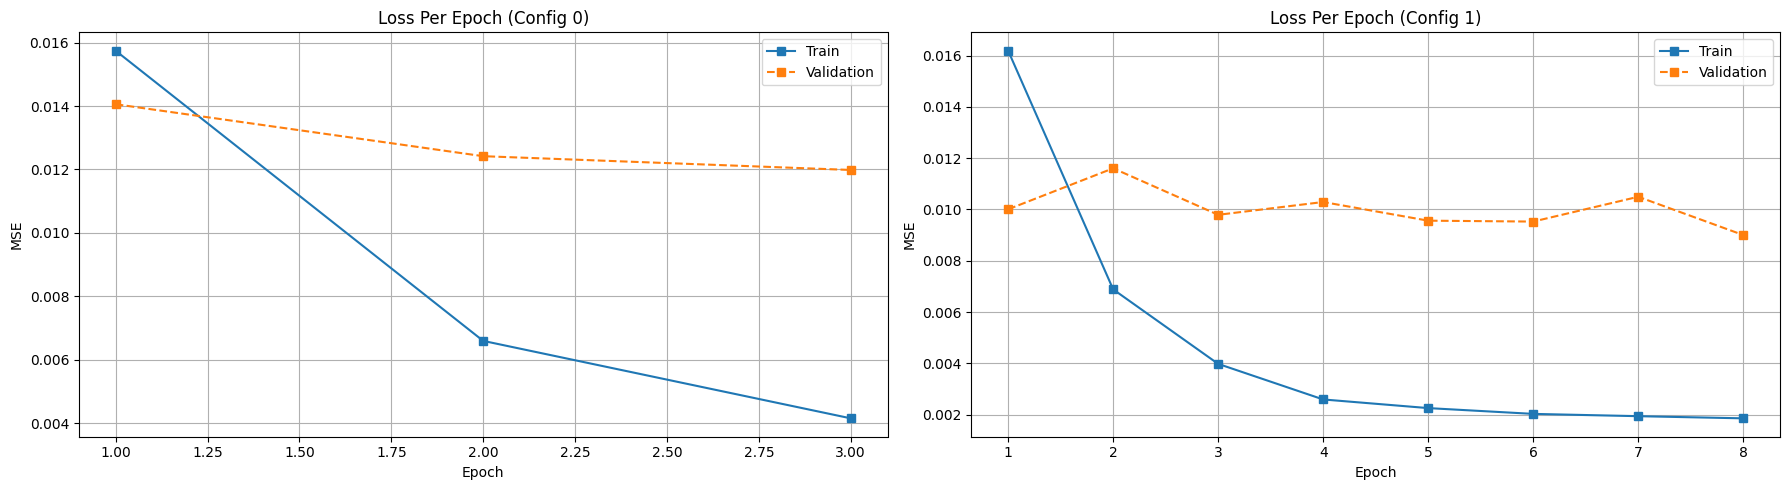

In [3]:
metrics = ['mse']
titles = {
    'mse': 'Loss Per Epoch'
}

fig, axes = plt.subplots(1, 2, figsize=(18, 5))  # 1 row, 3 columns

for i, row in enumerate(config_df.itertuples(index=False)):
    
    config_id = row.config_id
    data = epoch_df[epoch_df['config_id'] == config_id]
    
    epochs = data['epoch'].iloc[:-5]
    
    for metric in metrics:
        train_metric = data[f'train_{metric}'].iloc[:-5]
        valid_metric = data[f'valid_{metric}'].iloc[:-5]

        ax = axes[i]
        ax.plot(epochs, train_metric, linestyle='-', marker='s', label='Train')
        ax.plot(epochs, valid_metric, linestyle='--', marker='s', label='Validation')
        
        ax.set_title(f"{titles[metric]} (Config {config_id})")
        ax.set_xlabel("Epoch")
        ax.set_ylabel(metric.upper())
        ax.legend()
        ax.grid(True)

plt.tight_layout()
plt.show()


# Scatter Plot with Regression Line

In [4]:
import sys
import os
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', '..'))
sys.path.append(src_path)
from transformers import AutoTokenizer
from main_similarity import SiameseModel, AutomaticScoringDataset
from torch.utils.data import DataLoader
import torch
import joblib
import torch.nn.functional as F

tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/distiluse-base-multilingual-cased-v2')
model = SiameseModel('sentence-transformers/distiluse-base-multilingual-cased-v2', pooling_type='mean').to('cuda')

def compute_cosine_similarity(dataloader):
    all_outputs = []
    all_scores = []
    with torch.no_grad():
        for batchs in dataloader:
            batchs = {
                k: {kk: vv.to("cuda") for kk, vv in v.items()} if isinstance(v, dict) else v.to("cuda")
                for k, v in batchs.items()
            }
            
            # get embedding for each student and reference answer
            reference_emb = model(batchs['reference_answer']['input_ids'], batchs['reference_answer']['attention_mask'])
            student_emb = model(batchs['student_answer']['input_ids'], batchs['student_answer']['attention_mask'])
            scores = batchs['labels'].float().view(-1)

            # Normalize embeddings
            ref_embedding = F.normalize(reference_emb, p=2, dim=1)
            student_embedding = F.normalize(student_emb, p=2, dim=1)

            # get cosine similarity
            similarity = F.cosine_similarity(ref_embedding, student_embedding, dim=1)
            similarity = torch.clamp(similarity, -1.0, 1.0)

            all_outputs.append(similarity)
            all_scores.append(scores)

    # Concatenate all batches
    X = torch.cat(all_outputs, dim=0).cpu().numpy()
    y = torch.cat(all_scores, dim=0).cpu().numpy()

    return X, y

def predict(df_test, config_id):
    test_data = AutomaticScoringDataset(df_test, tokenizer)
    test_dataloader = DataLoader(test_data, batch_size=16, shuffle=False, generator=torch.Generator().manual_seed(42), num_workers=0)
    
    checkpoint = torch.load(f"../../../models/preprocessing/spesific/sbert_{config_id}.pt", map_location='cuda', weights_only=True)
    model.load_state_dict(checkpoint)
    model.eval()
    reg_model = joblib.load(f"../../../models/preprocessing/spesific/reg_{config_id}.pkl")
    X_test, y_test = compute_cosine_similarity(test_dataloader)
    y_test_pred = reg_model.predict(X_test.reshape(-1, 1))

    return y_test_pred, y_test

def save_predictions(df_test, output_path):
    columns_to_keep = ['question', 'reference_answer', 'answer', 'normalized_score', 'dataset_num']
    columns_to_keep += [col for col in df_test.columns if col.startswith("predicted_score_")]
    df_test = df_test[columns_to_keep]
    df_test.to_csv(output_path, index=False)

In [5]:
import pandas as pd

df1 = config_df[config_df['dataset_type'] == 'before preprocessing']
df2 = config_df[config_df['dataset_type'] == 'after preprocessing']

# before preprocessing
df_test1 = pd.read_csv("../../../../data/spesific/test_indo.csv")
for row in df1.itertuples():
    all_predictions, all_targets = predict(df_test1, row.config_id)

    # Tambahkan prediksi ke df_test
    df_test1[f"predicted_score_{row.config_id}"] = all_predictions

output_dir = "inference"
os.makedirs(output_dir, exist_ok=True)

save_predictions(df_test1, os.path.join(output_dir, "sbert_predictions1.csv"))

# after preprocessing
df_test2 = pd.read_csv("../../../../data/clean/spesific/test_indo.csv")
for row in df2.itertuples():
    all_predictions, all_targets = predict(df_test2, row.config_id)

    # Tambahkan prediksi ke df_test
    df_test2[f"predicted_score_{row.config_id}"] = all_predictions

save_predictions(df_test2, os.path.join(output_dir, "sbert_predictions2.csv"))

c:\Users\User\Documents\Code\env\lib\site-packages\transformers\models\distilbert\modeling_distilbert.py:402: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(



>> Tanpa Praproses - predicted_score_0
RMSE: 0.0979, Pearson: 0.9334

>> Dengan Praproses - predicted_score_1
RMSE: 0.1024, Pearson: 0.9222


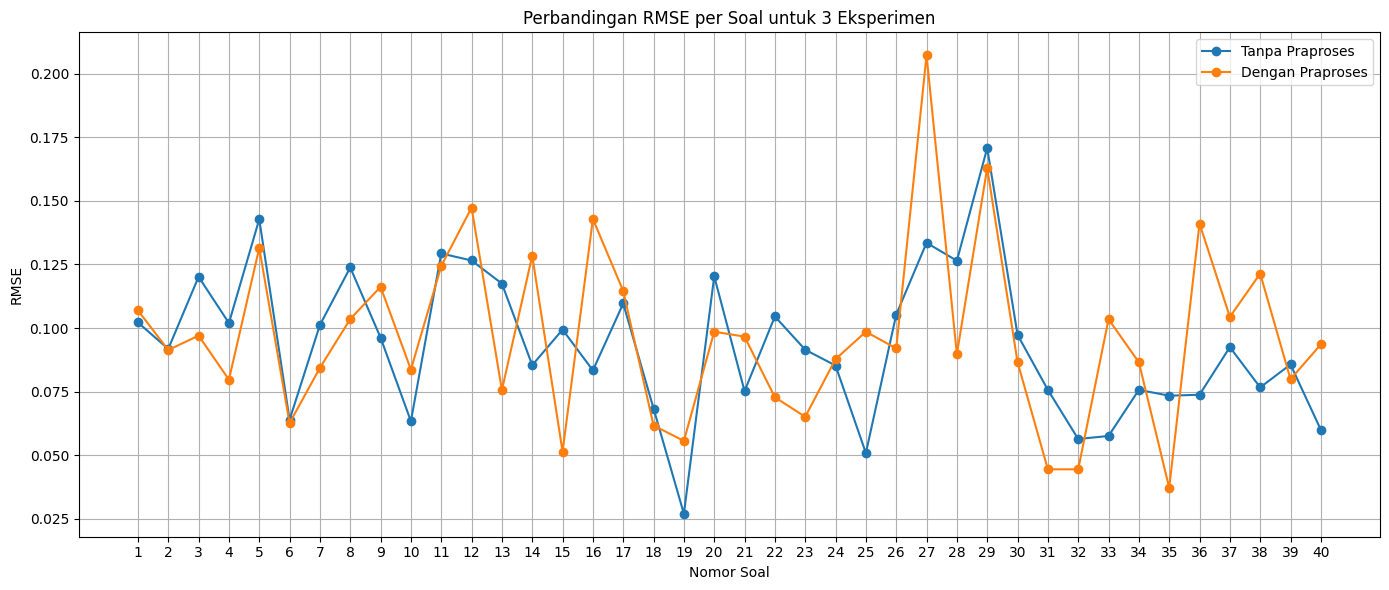

In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from scipy.stats import pearsonr
from tabulate import tabulate

# Folder inference
inference_dir = "inference"
csv_files = [f for f in os.listdir(inference_dir) if f.endswith(".csv") and f.startswith("sbert")]

# Warna akan di-generate otomatis tergantung jumlah eksperimen
color_palette = plt.get_cmap("tab10")  # Bisa memuat hingga 10 warna berbeda

# Label eksperimen bisa ditentukan manual berdasarkan nama kolom prediksi
label_map = {
    "predicted_score_0": "Tanpa Praproses",
    "predicted_score_1": "Dengan Praproses"
}

# Dictionary untuk menyimpan RMSE per soal dari tiap eksperimen
rmse_per_model = {}

# Buat scatter plot dan hitung RMSE per soal
model_idx = 0
for file in csv_files:
    file_path = os.path.join(inference_dir, file)
    df = pd.read_csv(file_path)

    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]

    for col in pred_cols:
        pred_scores = df[col].values
        residuals = pred_scores - true_scores

        # Hitung metrik global
        rmse = root_mean_squared_error(true_scores, pred_scores)
        pearson, _ = pearsonr(true_scores, pred_scores)

        label = label_map.get(col, col)  # Default pakai nama kolom kalau tidak ditemukan
        print(f"\n>> {label} - {col}")
        print(f"RMSE: {rmse:.4f}, Pearson: {pearson:.4f}")

        # Hitung RMSE per soal
        rmse_per_soal = df.groupby('dataset_num').apply(lambda x: root_mean_squared_error(x['normalized_score'], x[col]), include_groups=False)
        rmse_per_model[label] = rmse_per_soal
        model_idx += 1

# Ekstrak nomor soal dari dataset_num (misalnya 'analisis_essay-19' -> 19)
def extract_soal_number(index_series):
    return index_series.astype(str).str.extract(r'(\d+)$').astype(int)[0]

# Plot gabungan RMSE per soal
plt.figure(figsize=(14, 6))
for i, label in enumerate(rmse_per_model):
    rmse_series = rmse_per_model[label]
    
    # Ekstrak nomor soal
    soal_numbers = extract_soal_number(rmse_series.index)
    
    # Gabungkan kembali ke Series dengan index numerik
    rmse_series.index = soal_numbers
    rmse_series = rmse_series.sort_index()
    
    # Plot
    plt.plot(rmse_series.index, rmse_series.values, marker='o', linestyle='-', label=label)

plt.title("Perbandingan RMSE per Soal untuk 3 Eksperimen")
plt.xlabel("Nomor Soal")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()
plt.xticks(ticks=sorted(rmse_series.index.unique()))  # Lebih rapi dan terbaca
plt.tight_layout()
plt.show()



Dengan Praproses:
  Outlier (IQR Global): 7
  Outlier (Fixed ±0.1): 58

Tanpa Praproses:
  Outlier (IQR Global): 3
  Outlier (Fixed ±0.1): 77



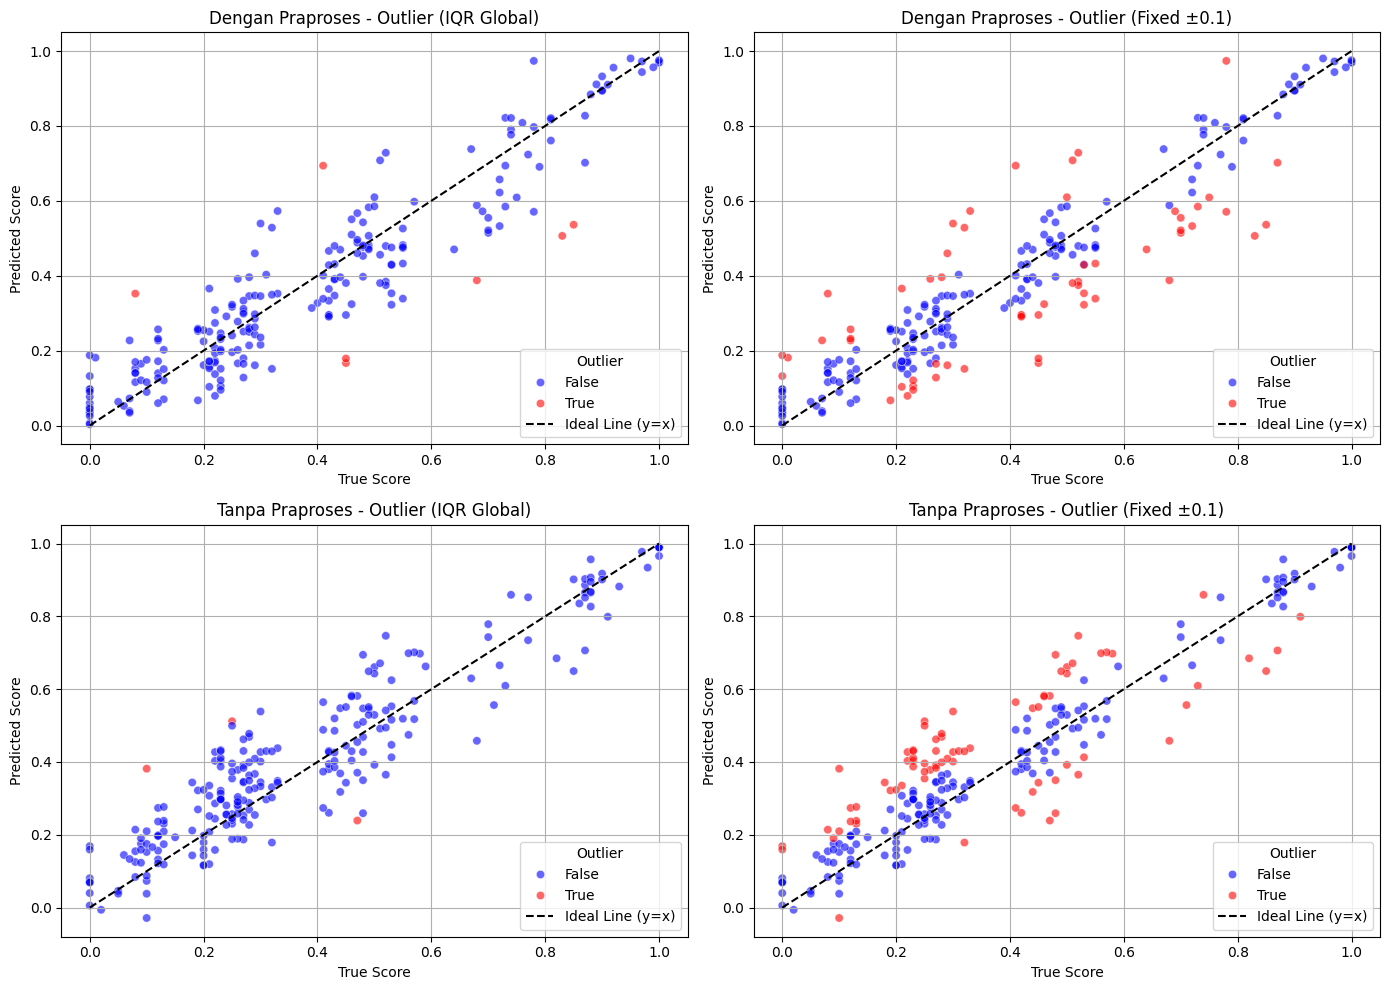

In [13]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

fixed_threshold = 0.1

# Gabungkan semua residual untuk IQR Global
all_residual_values = []

model_data = []

for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]

    for col in pred_cols:
        pred_scores = df[col].values
        residuals = pred_scores - true_scores
        label = label_map.get(col, col)
        model_data.append((label, true_scores, pred_scores, residuals))
        all_residual_values.extend(residuals)

model_data = sorted(model_data, key=lambda x: x[0])

# Hitung IQR global
q1 = np.percentile(all_residual_values, 25)
q3 = np.percentile(all_residual_values, 75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Visualisasi scatter plot untuk tiap model
num_models = len(model_data)
fig, axes = plt.subplots(num_models, 2, figsize=(14, 5 * num_models))

for i, (label, true_scores, pred_scores, residuals) in enumerate(model_data):
    # Deteksi outlier IQR global & fixed threshold
    outlier_iqr = (residuals < lower_bound) | (residuals > upper_bound)
    outlier_fixed = np.abs(residuals) > fixed_threshold

    # Kolom kiri: IQR Global
    sns.scatterplot(x=true_scores, y=pred_scores, hue=outlier_iqr,
                    palette={True: 'red', False: 'blue'}, alpha=0.6, ax=axes[i, 0])
    axes[i, 0].plot([0, 1], [0, 1], 'k--', label='Ideal Line (y=x)')
    axes[i, 0].set_title(f"{label} - Outlier (IQR Global)")
    axes[i, 0].set_xlabel("True Score")
    axes[i, 0].set_ylabel("Predicted Score")
    axes[i, 0].legend(title="Outlier", loc="lower right")
    axes[i, 0].grid()

    # Kolom kanan: Fixed Threshold
    sns.scatterplot(x=true_scores, y=pred_scores, hue=outlier_fixed,
                    palette={True: 'red', False: 'blue'}, alpha=0.6, ax=axes[i, 1])
    axes[i, 1].plot([0, 1], [0, 1], 'k--', label='Ideal Line (y=x)')
    axes[i, 1].set_title(f"{label} - Outlier (Fixed ±{fixed_threshold})")
    axes[i, 1].set_xlabel("True Score")
    axes[i, 1].set_ylabel("Predicted Score")
    axes[i, 1].legend(title="Outlier", loc="lower right")
    axes[i, 1].grid()

        # Hitung jumlah outlier
    num_outliers_iqr = np.sum(outlier_iqr)
    num_outliers_fixed = np.sum(outlier_fixed)

    # Cetak hasil
    print(f"{label}:")
    print(f"  Outlier (IQR Global): {num_outliers_iqr}")
    print(f"  Outlier (Fixed ±{fixed_threshold}): {num_outliers_fixed}\n")


plt.tight_layout()
plt.show()


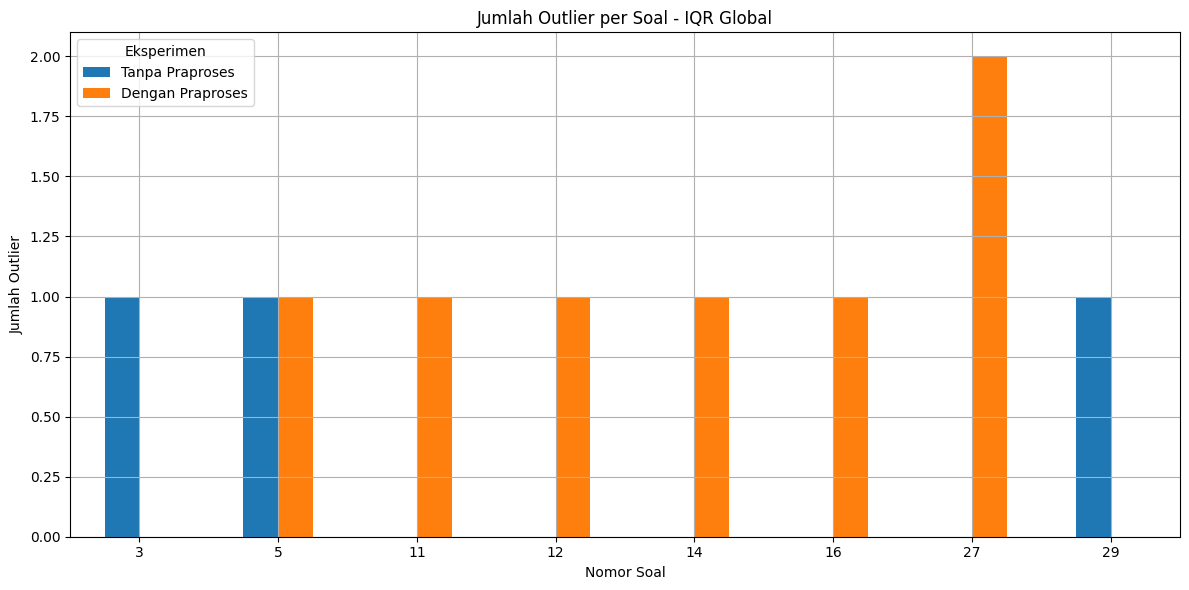


=== DATA OUTLIER BERDASARKAN IQR GLOBAL ===

IQR Outliers untuk eksperimen: Tanpa Praproses
+-------------------+------------+--------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------+--------------------+---------------------+
| dataset_num       |   soal_num | question                                                                                                           | reference_answer                                                                                                                                                                        | answer                                                                                 |   normaliz

In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Hitung residual gabungan untuk IQR global
all_residuals = []
outlier_counts_iqr = {}
outlier_counts_fixed = {}

for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]

    for col in pred_cols:
        residuals = df[col].values - true_scores
        all_residuals.extend(residuals)

# Step 2: Hitung batas bawah dan atas global IQR
q1 = np.percentile(all_residuals, 25)
q3 = np.percentile(all_residuals, 75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Fixed threshold
fixed_threshold = 0.1

# Step 3: Hitung jumlah outlier per soal (IQR Global & Fixed)
for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]
    df['soal_num'] = df['dataset_num'].str.extract(r'-(\d+)$').astype(int)

    for col in pred_cols:
        residuals = df[col].values - true_scores

        outlier_mask_iqr = (residuals < lower_bound) | (residuals > upper_bound)
        outlier_mask_fixed = np.abs(residuals) > fixed_threshold

        df['outlier_iqr'] = outlier_mask_iqr
        df['outlier_fixed'] = outlier_mask_fixed

        label = label_map.get(col, col)

        # IQR Global
        iqr_counts = df[df['outlier_iqr']].groupby('soal_num').size()
        outlier_counts_iqr[label] = iqr_counts

        # Fixed Threshold
        fixed_counts = df[df['outlier_fixed']].groupby('soal_num').size()
        outlier_counts_fixed[label] = fixed_counts

# Step 4: Gabungkan ke DataFrame dan isi kosong dengan nol
df_iqr = pd.DataFrame(outlier_counts_iqr).fillna(0).astype(int).sort_index()
df_fixed = pd.DataFrame(outlier_counts_fixed).fillna(0).astype(int).sort_index()

# Plot 1: IQR Global
fig1, ax1 = plt.subplots(figsize=(12, 6))
df_iqr.plot(kind='bar', ax=ax1)
ax1.set_title("Jumlah Outlier per Soal - IQR Global")
ax1.set_xlabel("Nomor Soal")
ax1.set_ylabel("Jumlah Outlier")
ax1.grid(True)
ax1.legend(title="Eksperimen")
ax1.tick_params(axis='x', rotation=0)
plt.tight_layout()
plt.show()

# # Plot 2: Fixed Threshold dengan ukuran lebih besar
# fig2, ax2 = plt.subplots(figsize=(18, 6))
# df_fixed.plot(kind='bar', ax=ax2)
# ax2.set_title("Jumlah Outlier per Soal - Threshold ±0.1")
# ax2.set_xlabel("Nomor Soal")
# ax2.set_ylabel("Jumlah Outlier")
# ax2.grid(True)
# ax2.legend(title="Eksperimen")
# ax2.tick_params(axis='x', rotation=0)
# plt.tight_layout()
# plt.show()

from tabulate import tabulate

# Tampilkan data outlier berdasarkan IQR Global
print("\n=== DATA OUTLIER BERDASARKAN IQR GLOBAL ===")
for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]
    df['soal_num'] = df['dataset_num'].str.extract(r'-(\d+)$').astype(int)

    for col in pred_cols:
        residuals = df[col].values - true_scores
        outlier_mask = (residuals < lower_bound) | (residuals > upper_bound)

        subset_iqr = df[outlier_mask][['dataset_num', 'soal_num', 'question', 'reference_answer', 'answer', 'normalized_score', col]]
        subset_iqr = subset_iqr[(subset_iqr['soal_num'] == 27) | (subset_iqr['soal_num'] == 29)]
        if not subset_iqr.empty:
            print(f"\nIQR Outliers untuk eksperimen: {label_map.get(col, col)}")
            print(tabulate(subset_iqr, headers='keys', tablefmt='grid', showindex=False))


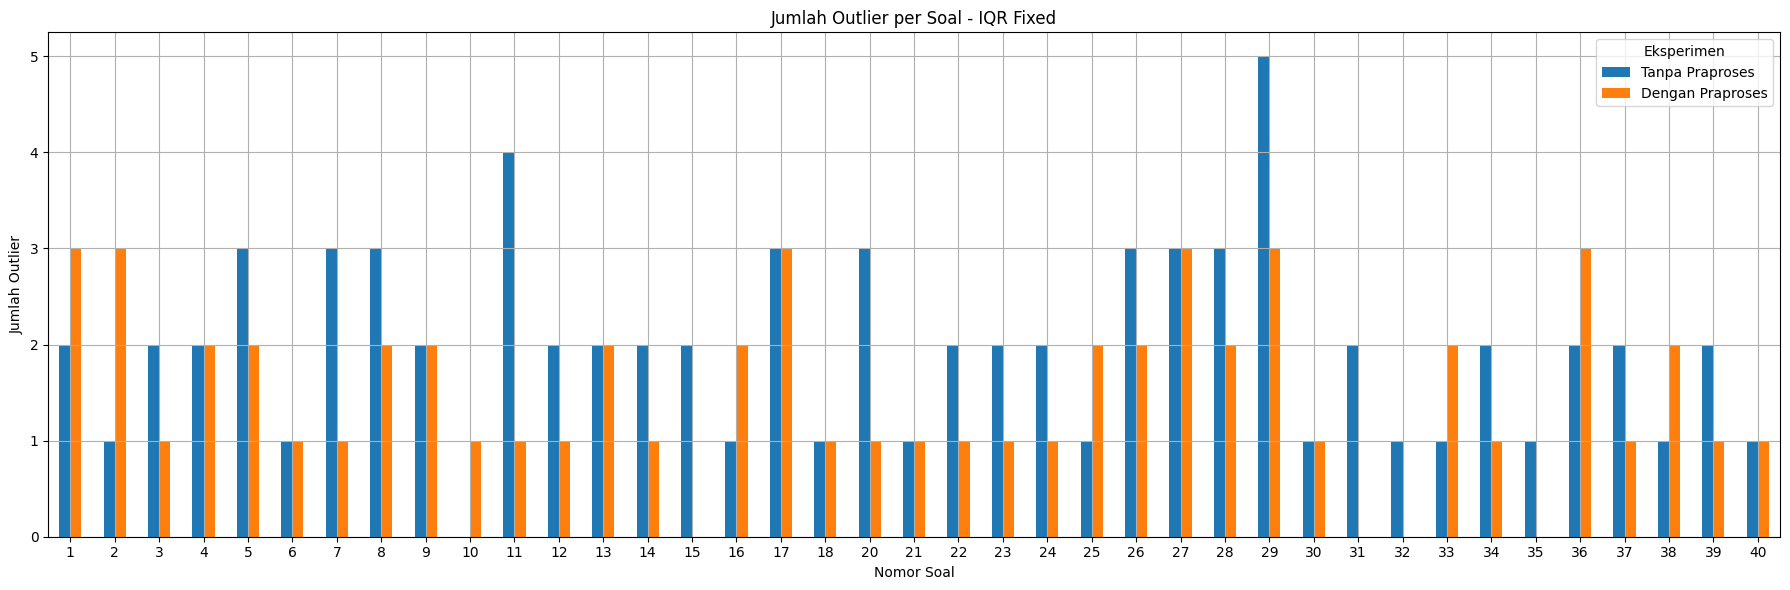


=== DATA OUTLIER BERDASARKAN IQR FIXED ===

IQR Outliers untuk eksperimen: Tanpa Praproses
+-------------------+------------+-----------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Hitung residual gabungan untuk IQR global
all_residuals = []
outlier_counts_iqr = {}
outlier_counts_fixed = {}

for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]

    for col in pred_cols:
        residuals = df[col].values - true_scores
        all_residuals.extend(residuals)

# Step 2: Hitung batas bawah dan atas global IQR
q1 = np.percentile(all_residuals, 25)
q3 = np.percentile(all_residuals, 75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Fixed threshold
fixed_threshold = 0.1

# Step 3: Hitung jumlah outlier per soal (IQR Global & Fixed)
for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]
    df['soal_num'] = df['dataset_num'].str.extract(r'-(\d+)$').astype(int)

    for col in pred_cols:
        residuals = df[col].values - true_scores

        outlier_mask_iqr = (residuals < lower_bound) | (residuals > upper_bound)
        outlier_mask_fixed = np.abs(residuals) > fixed_threshold

        df['outlier_iqr'] = outlier_mask_iqr
        df['outlier_fixed'] = outlier_mask_fixed

        label = label_map.get(col, col)

        # IQR Global
        iqr_counts = df[df['outlier_iqr']].groupby('soal_num').size()
        outlier_counts_iqr[label] = iqr_counts

        # Fixed Threshold
        fixed_counts = df[df['outlier_fixed']].groupby('soal_num').size()
        outlier_counts_fixed[label] = fixed_counts

# Step 4: Gabungkan ke DataFrame dan isi kosong dengan nol
df_iqr = pd.DataFrame(outlier_counts_iqr).fillna(0).astype(int).sort_index()
df_fixed = pd.DataFrame(outlier_counts_fixed).fillna(0).astype(int).sort_index()

# Plot 1: IQR Fixed
fig1, ax1 = plt.subplots(figsize=(18, 6))
df_fixed.plot(kind='bar', ax=ax1)
ax1.set_title("Jumlah Outlier per Soal - IQR Fixed")
ax1.set_xlabel("Nomor Soal")
ax1.set_ylabel("Jumlah Outlier")
ax1.grid(True)
ax1.legend(title="Eksperimen")
ax1.tick_params(axis='x', rotation=0)
plt.tight_layout()
plt.show()

from tabulate import tabulate

# Tampilkan data outlier berdasarkan IQR Fixed
print("\n=== DATA OUTLIER BERDASARKAN IQR FIXED ===")
for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]
    df['soal_num'] = df['dataset_num'].str.extract(r'-(\d+)$').astype(int)

    for col in pred_cols:
        residuals = df[col].values - true_scores
        outlier_mask = np.abs(residuals) > fixed_threshold

        subset_iqr = df[outlier_mask][['dataset_num', 'soal_num', 'question', 'reference_answer', 'answer', 'normalized_score', col]]
        # subset_iqr = subset_iqr[(subset_iqr['soal_num'] == 27) | (subset_iqr['soal_num'] == 29)]
        if not subset_iqr.empty:
            print(f"\nIQR Outliers untuk eksperimen: {label_map.get(col, col)}")
            print(tabulate(subset_iqr, headers='keys', tablefmt='grid', showindex=False))
